In [1]:
import math
import pandas as pd
import tensorflow as tf
# import keras_tuner.tuners as kt
import matplotlib.pyplot as plt
import keras
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError
import numpy as np
import pickle
np.random.seed(0)
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv1D, Conv2D, LeakyReLU, MaxPool1D, AveragePooling1D, UpSampling1D, Flatten, Dense, Reshape, BatchNormalization
# https://towardsdatascience.com/improve-your-model-performance-with-auto-encoders-d4ee543b4154
from tensorflow.keras import initializers
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from scipy.stats import multivariate_normal
from keras.optimizers import Adam, SGD, Adadelta



In [2]:
x_train_scaled = pd.read_csv('../260_sample_train_scaled.csv').set_index("Patient_ID")
x_train_scaled

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,TAF15,ZFYVE20,LOC100420253,LY6G5B,C5orf58,RSL24D1P1,MIEN1,PCBP1_AS1,LOC100133165,DNAJB8
Patient_ID,,,,,,,,,,,,,,,,,,,,,
55_control,0.702813,0.799052,0.719665,0.729547,0.794953,0.256451,1.000000,0.363133,0.374212,0.611161,...,0.468042,0.335792,0.0,0.609518,0.535456,0.0,0.543158,0.622641,0.0,1.0
168_CD_plain,0.751408,0.603707,0.622768,0.627712,0.606860,0.520576,0.311962,0.251356,0.553554,0.441131,...,0.000000,0.159464,0.0,0.173529,0.018188,0.0,0.623796,0.301179,0.0,0.0
72_control,0.786508,0.755331,0.739605,0.756170,0.819875,0.391132,0.648401,0.134017,0.200420,0.679453,...,0.335173,0.241577,0.0,0.659563,0.000000,0.0,0.853118,0.431083,0.0,0.0
120_control,0.707491,0.662993,0.648072,0.764621,0.654276,0.633929,0.579519,0.248934,0.759250,0.755407,...,0.181256,0.297248,0.0,0.837676,0.480372,0.0,0.392582,0.390569,0.0,0.0
258_CD_plain,0.701039,0.662511,0.707208,0.834562,0.670160,0.410612,0.370517,0.244987,0.445387,0.798000,...,0.319013,0.306320,0.0,0.893448,0.485539,0.0,0.259900,0.431818,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15_CD_plain,0.382762,0.384030,0.377332,0.360165,0.300915,0.340090,0.077348,0.890965,0.261140,0.205779,...,0.209212,0.301844,0.0,0.643267,0.143476,0.0,0.262892,0.189790,0.0,0.0
182_CD_plain,0.679910,0.584723,0.722426,0.643867,0.740014,0.650358,0.468650,0.295686,0.649939,0.609862,...,0.408592,0.042243,0.0,0.765285,0.527984,0.0,0.413798,0.270021,0.0,0.0
164_CD_plain,0.754656,0.556562,0.694062,0.748334,0.535534,0.133869,0.319071,0.154562,0.440487,0.824013,...,0.514164,0.364434,0.0,0.930260,0.481733,0.0,0.273699,0.433093,0.0,0.0


In [3]:
x_test_scaled = pd.read_csv('../260_sample_test_scaled.csv').set_index("Patient_ID")
x_test_scaled

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,TAF15,ZFYVE20,LOC100420253,LY6G5B,C5orf58,RSL24D1P1,MIEN1,PCBP1_AS1,LOC100133165,DNAJB8
Patient_ID,,,,,,,,,,,,,,,,,,,,,
253_CD_plain,0.869185,0.841880,0.930171,0.886737,0.835678,0.297964,0.668498,0.266670,0.278122,0.933520,...,0.339788,0.326732,0.0,0.862246,0.074473,0.0,0.498941,0.349920,0.0,0.0
105_CD_plain,0.853562,0.933532,0.942213,0.794578,0.890482,0.206529,0.298987,0.350745,0.495663,0.849038,...,0.354602,-0.031527,0.0,0.717305,0.039214,0.0,0.697073,0.268224,0.0,0.0
2_CD_plain,0.165531,0.141475,0.263684,0.198091,0.160503,0.888878,0.000000,0.134461,0.989132,0.202203,...,0.320002,0.379134,0.0,0.604202,0.610072,0.0,0.324065,0.375123,0.0,0.0
184_CD_plain,0.717121,0.660314,0.769417,0.752737,0.694874,0.514735,0.692365,0.271127,0.650742,0.694599,...,0.445680,0.178908,0.0,0.702114,0.325357,0.0,0.390919,0.185509,0.0,0.0
312_CD_plain,0.730072,0.722909,0.713076,0.743545,0.679258,0.308459,0.399235,0.129019,0.597529,0.720390,...,0.419254,0.312215,0.0,0.821584,0.632007,0.0,0.183158,0.271359,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107_CD_plain,0.736123,0.658232,0.772323,0.685637,0.658755,0.250970,0.247307,0.422075,0.555944,0.603675,...,0.379431,0.233196,0.0,0.759342,0.567491,0.0,0.404604,0.190411,0.0,0.0
279_CD_plain,0.220614,0.202090,0.182810,0.113245,0.105744,0.699851,0.000000,0.908485,0.688912,0.178259,...,0.181052,0.342262,0.0,0.639644,0.540444,0.0,0.397274,0.061934,0.0,0.0
179_CD_plain,0.724476,0.726774,0.766943,0.776284,0.690339,0.380637,0.440449,0.318944,0.558600,0.738787,...,0.331961,0.275577,0.0,0.886616,0.658049,0.0,0.259391,0.471132,0.0,0.0


In [4]:
patient_ids_train = np.array(x_train_scaled.index)
patient_ids_test = np.array(x_test_scaled.index)
patient_ids_train

array(['55_control', '168_CD_plain', '72_control', '120_control',
       '258_CD_plain', '254_CD_deep_ulcer', '9_CD_plain', '111_CD_plain',
       '57_CD_plain', '216_CD_deep_ulcer', '263_CD_deep_ulcer',
       '95_CD_deep_ulcer', '31_control', '172_CD_plain', '310_CD_plain',
       '68_CD_plain', '65_control', '285_CD_plain', '201_CD_plain',
       '223_CD_deep_ulcer', '320_CD_plain', '8_CD_plain',
       '99_CD_deep_ulcer', '90_control', '296_CD_deep_ulcer',
       '219_CD_deep_ulcer', '138_CD_deep_ulcer', '38_control',
       '113_CD_plain', '76_control', '146_CD_deep_ulcer',
       '147_CD_deep_ulcer', '186_CD_plain', '158_CD_plain',
       '299_CD_plain', '178_CD_plain', '189_CD_plain', '266_CD_plain',
       '231_CD_deep_ulcer', '198_CD_plain', '6_CD_deep_ulcer',
       '30_CD_plain', '265_CD_plain', '181_CD_deep_ulcer', '16_CD_plain',
       '264_CD_deep_ulcer', '209_CD_plain', '83_control', '214_CD_plain',
       '193_CD_deep_ulcer', '104_CD_plain', '66_CD_plain', '188_CD_plain

In [5]:
def classify(x):
    if "_control" in x: # control
        return 0
    elif "CD_plain" in x: # Crohn's Disease no deep ulcer
#         print(x)
        return 1
    elif "CD_deep_ulcer" in x: # Crohn's Disease deep ulcer
#         print(x)
        return 2
    else:
        return 3 # Ulcerative Collitis

vec = np.vectorize(classify)

disease_labels_train = vec(patient_ids_train)
disease_labels_test = vec(patient_ids_test)
disease_labels_train

array([0, 1, 0, 0, 1, 2, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 0, 1, 1, 2, 1, 1,
       2, 0, 2, 2, 2, 0, 1, 0, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2,
       1, 2, 1, 0, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 2, 2, 2, 1, 0, 0, 0, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 0, 1, 2,
       1, 2, 0, 0, 1, 2, 2, 1, 1, 2, 2, 0, 1, 2, 1, 2, 1, 0, 2, 1, 1, 1,
       2, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 0, 1, 1, 0, 2, 2, 2, 0, 1, 1, 2,
       2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 1, 1, 1, 1, 2, 1, 1,
       1, 2, 1, 1, 0, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 2, 0,
       0, 1, 1, 1, 1, 1])

In [6]:
compound_model = keras.models.load_model('cd_clf')

In [7]:
compound_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 438)               96360     
                                                                 
 batch_normalization (BatchN  (None, 438)              1752      
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 438)               0         
                                                                 
 dense_1 (Dense)             (None, 219)               96141     
                                                                 
 batch_normalization_1 (Batc  (None, 219)              876       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 219)               0

## SHAP evaluation

In [8]:
x_test_scaled.iloc[:2,:2]

,AADAC,APOA1
Patient_ID,,
253_CD_plain,0.869185,0.841880
105_CD_plain,0.853562,0.933532


In [9]:
import objects

In [10]:
explainer = objects.get_explainer(model=compound_model.predict, data=x_train_scaled, link="logit")

getting explainerinitialising explainer
6/6 [==============================] - 0s 2ms/step


Using 182 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


## Calculate SHAP values

In [11]:
# shap_values = explainer.shap_values(X=x_test_scaled)

In [12]:
# shap_values

## Save SHAP values

In [13]:
# with open("shap_values", "wb") as fp:   #Pickling
#     pickle.dump(shap_values, fp)

In [14]:


with open("shap_values_fd_kl", "rb") as fp:   # Unpickling
    shap_values = pickle.load(fp)

In [15]:
shap_values = shap_values[0]

In [16]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[0].shape}')

length of SHAP values: 3
Shape of each element: (78, 219)


Target Classes:
0: control
1: CD no ulcer
2: CD deep ulcer

## Patient-specific plots

In [17]:
idx = 11
patient = x_test_scaled.iloc[[idx],:]
patient

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,TAF15,ZFYVE20,LOC100420253,LY6G5B,C5orf58,RSL24D1P1,MIEN1,PCBP1_AS1,LOC100133165,DNAJB8
Patient_ID,,,,,,,,,,,,,,,,,,,,,
58_CD_plain,0.712765,0.67885,0.86582,0.855696,0.828452,0.498697,0.567772,0.352862,0.317254,0.76505,...,0.211571,0.283032,0.0,0.703328,0.556984,0.0,0.415272,0.225017,0.0,0.0


In [18]:
x_test_scaled.iloc[[0],:]

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,TAF15,ZFYVE20,LOC100420253,LY6G5B,C5orf58,RSL24D1P1,MIEN1,PCBP1_AS1,LOC100133165,DNAJB8
Patient_ID,,,,,,,,,,,,,,,,,,,,,
253_CD_plain,0.869185,0.84188,0.930171,0.886737,0.835678,0.297964,0.668498,0.26667,0.278122,0.93352,...,0.339788,0.326732,0.0,0.862246,0.074473,0.0,0.498941,0.34992,0.0,0.0


In [19]:
print(f'Prediction probabilities for patient: {compound_model.predict(patient)[0]}')
print("Predicted class:")

1/1 [==============================] - 0s 57ms/step
Prediction probabilities for patient: [0.05036432 0.7218582  0.22777751]
Predicted class:


#### Control

In [20]:
import shap

In [21]:

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][idx,:], patient, link="logit")

####  CD no ulcer

In [22]:

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][idx,:], patient, link="logit")

####  CD deep ulcer

In [23]:

shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][idx,:], patient, link="logit")

In [24]:
# gene_shap.plots.bar(Explanation(x_test_scaled)[0], clustering=clustering)
idx = 11
explanation = objects.get_explanation(values=shap_values[2][idx], 
                                              base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
                                         feature_names=x_test_scaled.columns.tolist())

type(explanation)

getting explanation


_explanation.Explanation

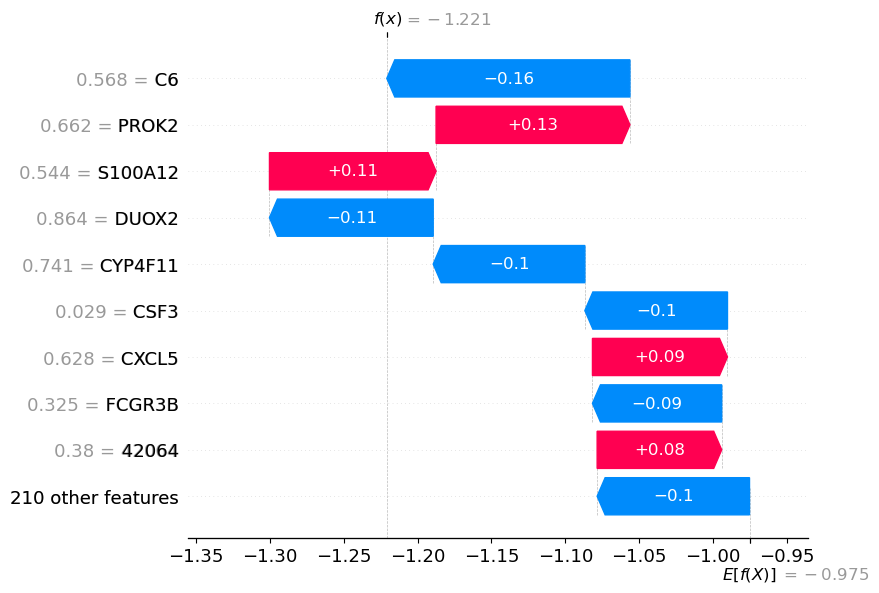

In [25]:
shap.waterfall_plot(explanation)
# shap.waterfall_plot(gene_shap.Explanation(values=shap_values[2][idx], 
#                                               base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
#                                          feature_names=x_test_scaled.columns.tolist()))

#### Control

In [26]:
# shap.initjs()
# shap.force_plot(explainer.expected_value[0], shap_values[0], x_test_scaled)

####  CD no ulcer

In [27]:
# shap.initjs()
# shap.force_plot(explainer.expected_value[1], shap_values[1], x_test_scaled)

####  CD deep ulcer

In [28]:
# shap.initjs()
# shap.force_plot(explainer.expected_value[2], shap_values[2], x_test_scaled)

## SHAP Summary Plots

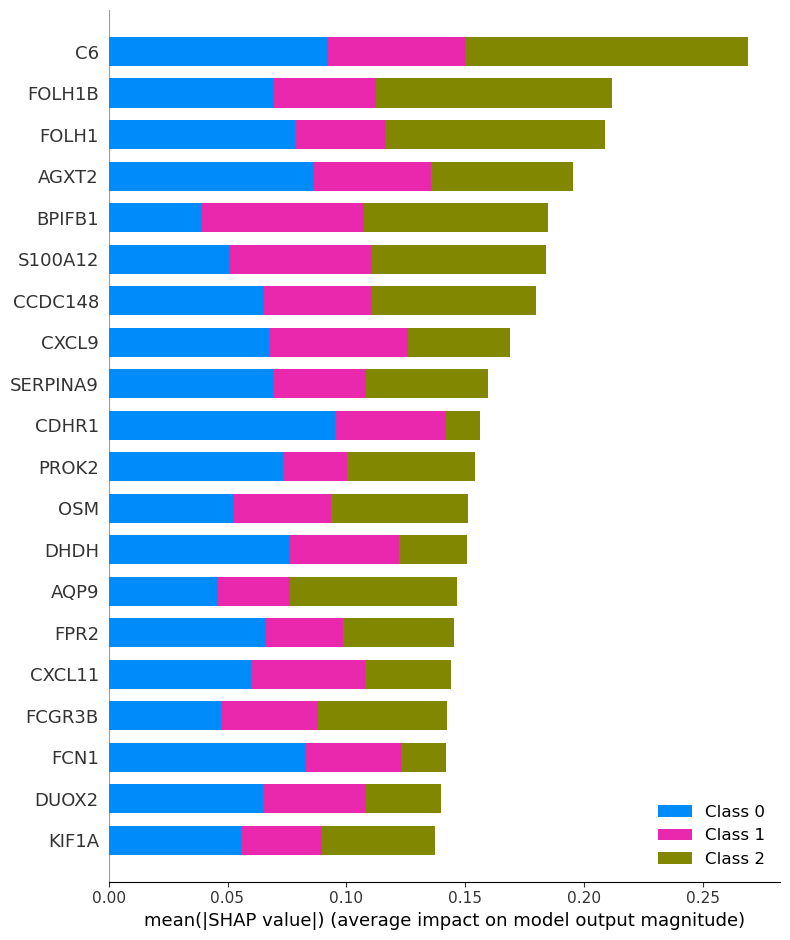

In [29]:
shap.summary_plot(shap_values, x_test_scaled)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


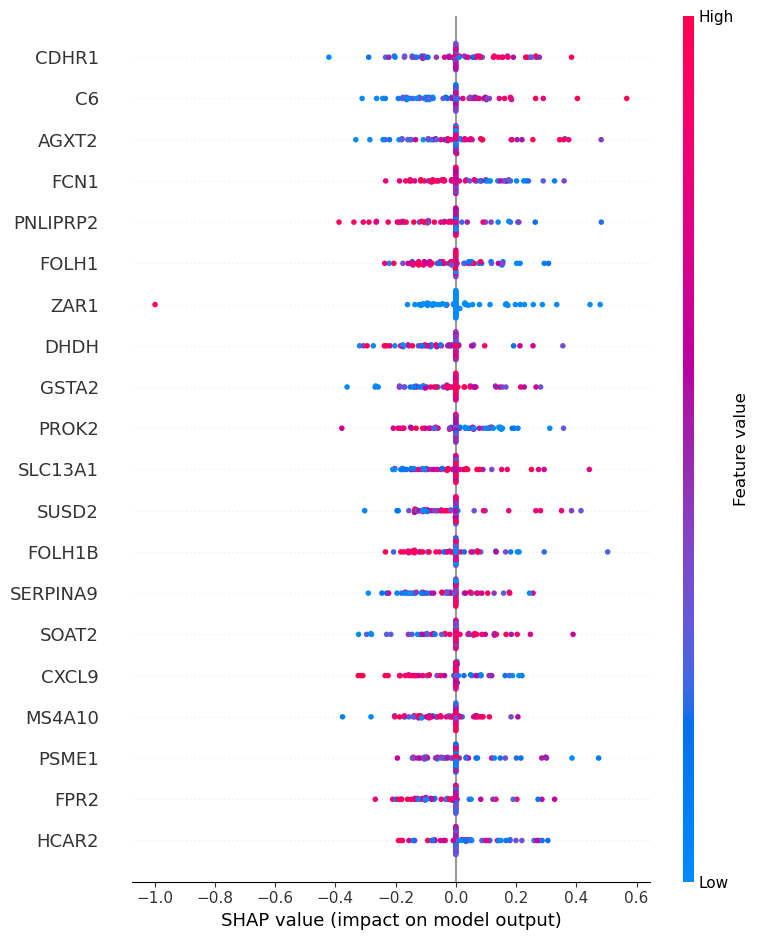

In [30]:
# control
shap.summary_plot(shap_values[0], x_test_scaled)

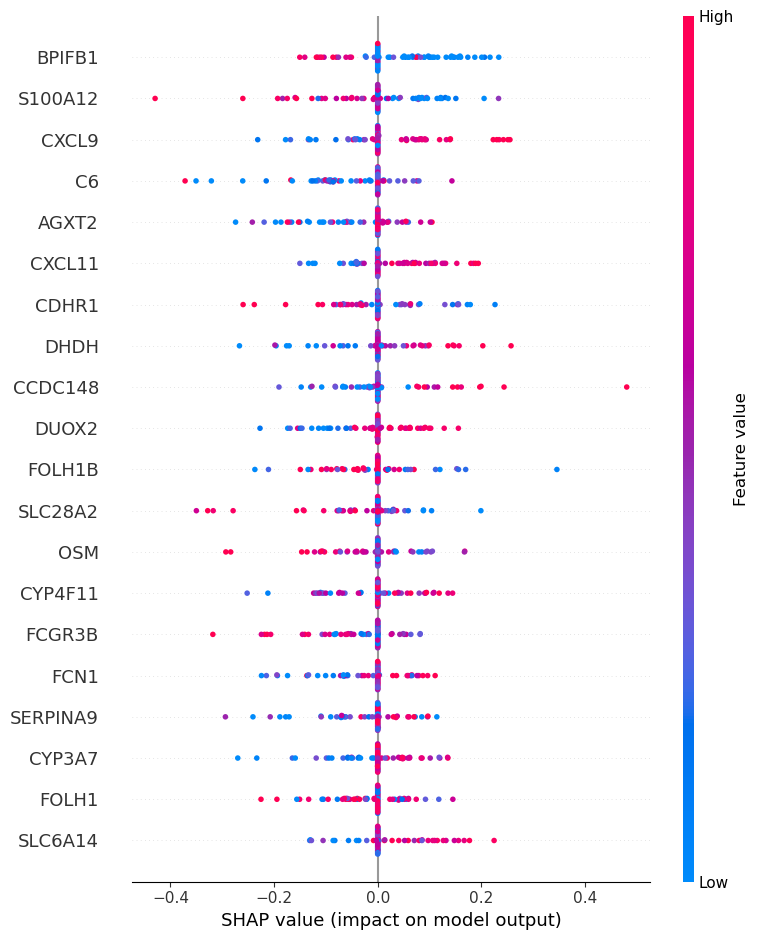

In [31]:
# CD no ulcer
shap.summary_plot(shap_values[1], x_test_scaled)

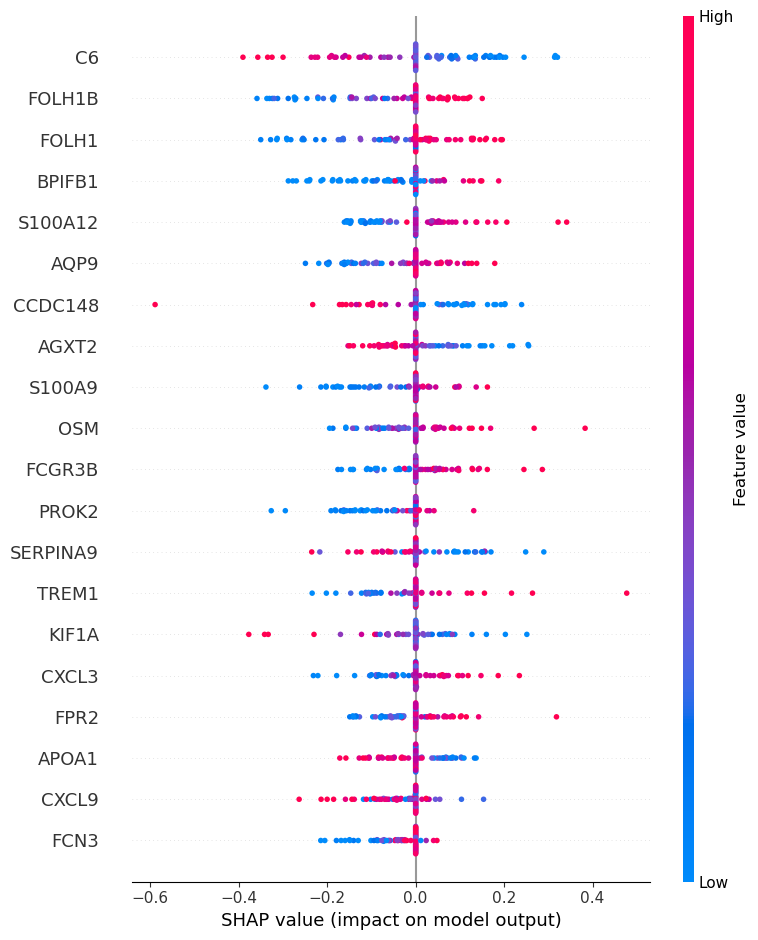

In [32]:
# CD deep ulcer
shap.summary_plot(shap_values[2], x_test_scaled)

## SHAP Dependence Plots

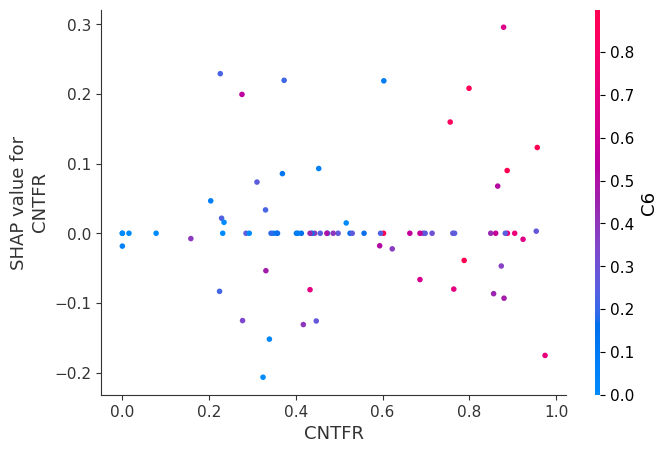

In [33]:
# control
shap.dependence_plot("CNTFR", shap_values[0], x_test_scaled)

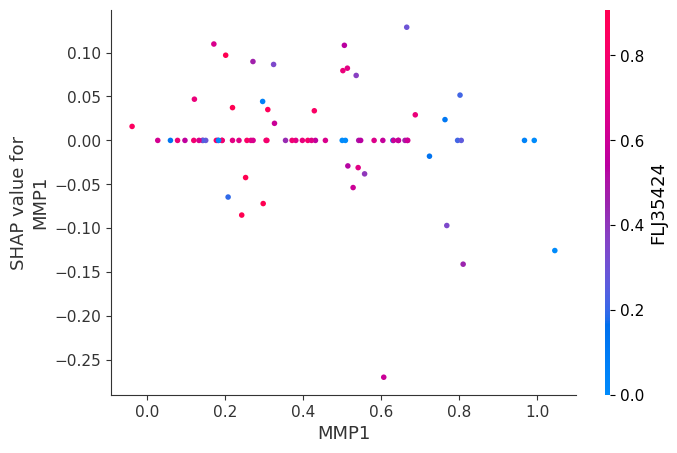

In [34]:
# CD no ulcer
shap.dependence_plot("MMP1", shap_values[1], x_test_scaled)

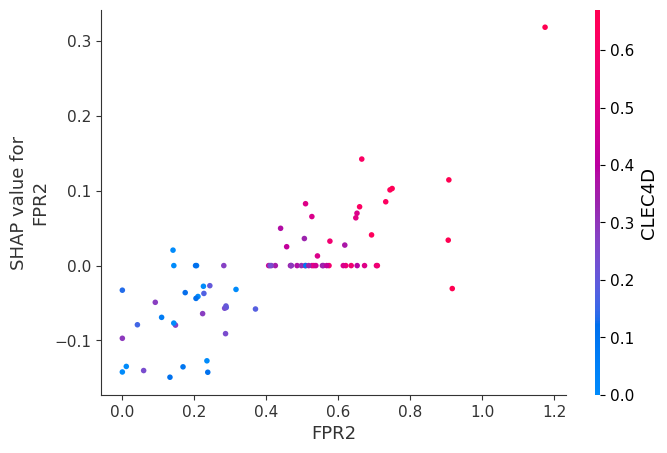

In [35]:
# CD deep ulcer
shap.dependence_plot("FPR2",shap_values[2], x_test_scaled)

## Clustering

In [36]:
disease_labels_test.shape

(78,)

In [37]:
# sys.stdout = open(1, 'w')
import sys
stdout = sys.stdout
sys.stdout = sys.__stdout__

### Current SHAP functionality

In [38]:
# clustering = objects.get_clustering(x_test_scaled, disease_labels_test)

In [39]:
# clustering

In [40]:
# clustering.shape

In [41]:
row = 70
exp = shap.Explanation(values=shap_values[2][row], base_values=explainer.expected_value[2], 
                                data=x_test_scaled.iloc[row], feature_names=x_test_scaled.columns.tolist())

# patient 8: explanations for CD deep ulcer diagnosis

In [42]:
type(exp)

shap._explanation.Explanation

In [43]:
# with open("clust", "wb") as fp:   #Pickling
#     pickle.dump(clustering, fp)

In [44]:

with open("../clust", "rb") as fp:   # Unpickling
    clustering = pickle.load(fp)

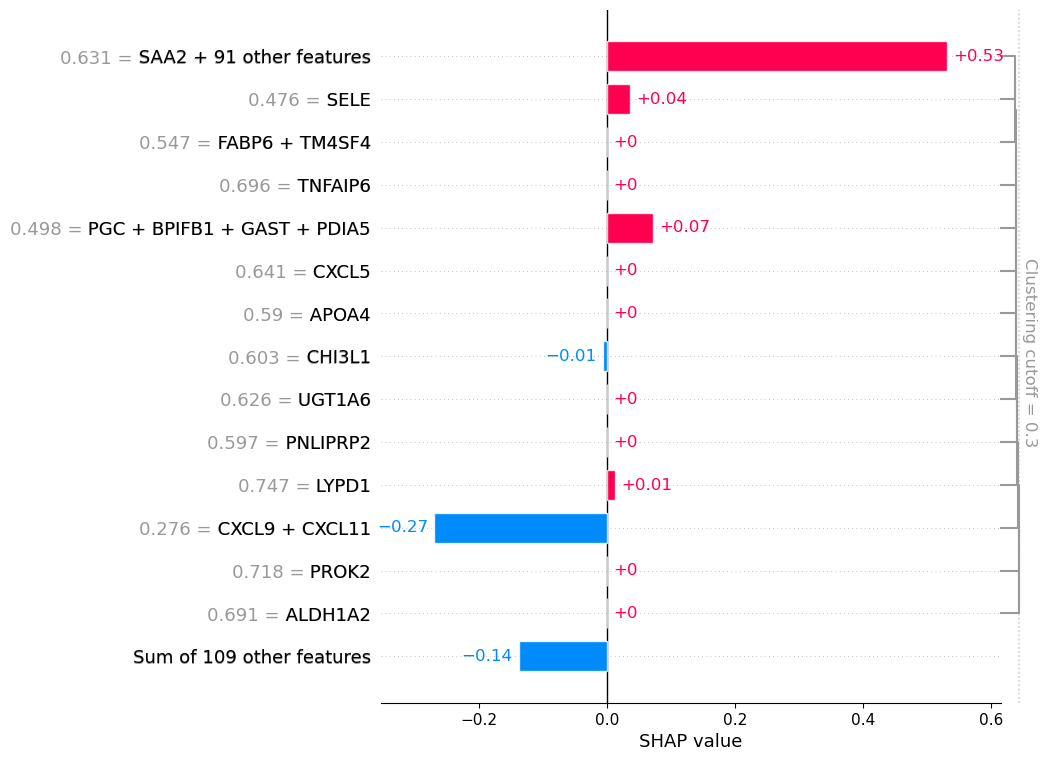

In [45]:
import shap
# shap.plots.bar(explanation, clustering=clustering)
shap.plots.bar(exp, max_display=15, clustering_cutoff=0.3,
               clustering=clustering)

## Hierarchical clustering of genes based on shap values, across all patients with given disease classification

In [46]:
from scipy.cluster.hierarchy import dendrogram, linkage, leaders, fcluster
import seaborn as sns

In [47]:


all_gene_df = pd.DataFrame(shap_values[2], index=x_test_scaled.index, columns = x_test_scaled.columns)
df_cd_deep = all_gene_df[all_gene_df.index.str.endswith('_CD_deep_ulcer')]
df_cd_plain = all_gene_df[all_gene_df.index.str.endswith('_CD_plain')]
df_control = all_gene_df[all_gene_df.index.str.endswith('_control')]
df_cd_deep

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,TAF15,ZFYVE20,LOC100420253,LY6G5B,C5orf58,RSL24D1P1,MIEN1,PCBP1_AS1,LOC100133165,DNAJB8
Patient_ID,,,,,,,,,,,,,,,,,,,,,
62_CD_deep_ulcer,0.000000,0.000000,-0.070018,-0.014483,0.038619,0.119072,0.169224,0.016117,0.000000,0.000000,...,0.013327,0.040196,0.0,0.000000,0.147607,0.0,0.044916,0.000000,0.0,0.000000
167_CD_deep_ulcer,0.000000,0.132873,0.000000,0.035029,0.000000,0.000000,0.090419,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.081228,0.0,0.000000,0.000000,0.0,0.064875
196_CD_deep_ulcer,0.000000,0.071837,-0.029792,0.006835,0.000000,0.138029,0.203294,0.067893,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,-0.001150,0.0,0.000000,0.000000,0.0,0.125373
23_CD_deep_ulcer,0.000000,0.102775,0.000000,0.000000,0.042356,0.000000,0.129363,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.026072,0.0,0.000000
93_CD_deep_ulcer,0.000000,0.036708,0.000000,0.000000,0.000000,0.000000,0.134668,-0.013352,-0.026500,0.048403,...,0.000000,-0.013416,0.0,0.000000,0.000000,0.0,0.000000,0.045196,0.0,0.000000
229_CD_deep_ulcer,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.190033,0.000000,-0.084570,0.000000,...,0.000000,-0.022348,0.0,-0.017804,0.000000,0.0,0.000000,0.000000,0.0,0.000000
46_CD_deep_ulcer,-0.021943,0.064903,-0.035029,0.082101,0.000000,0.077926,0.000000,0.018568,-0.010308,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.168920,0.0,0.091923
176_CD_deep_ulcer,0.000000,0.000000,0.000000,0.000000,0.000000,-0.020081,0.027971,-0.058676,-0.004927,-0.017174,...,0.000000,0.016648,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
49_CD_deep_ulcer,0.000000,0.000000,0.000000,0.083358,-0.067331,-0.157260,0.000000,0.059355,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,-0.016439,-0.025499,0.0,0.000000


### Example: CD deep ulcer patients

In [48]:
# patient_cluster_cd_deep = linkage(df_cd_deep, 'ward', metric='euclidean', optimal_ordering=True)
gene_cluster_cd_deep = linkage(df_cd_deep.T, 'ward', metric='euclidean', optimal_ordering=True)

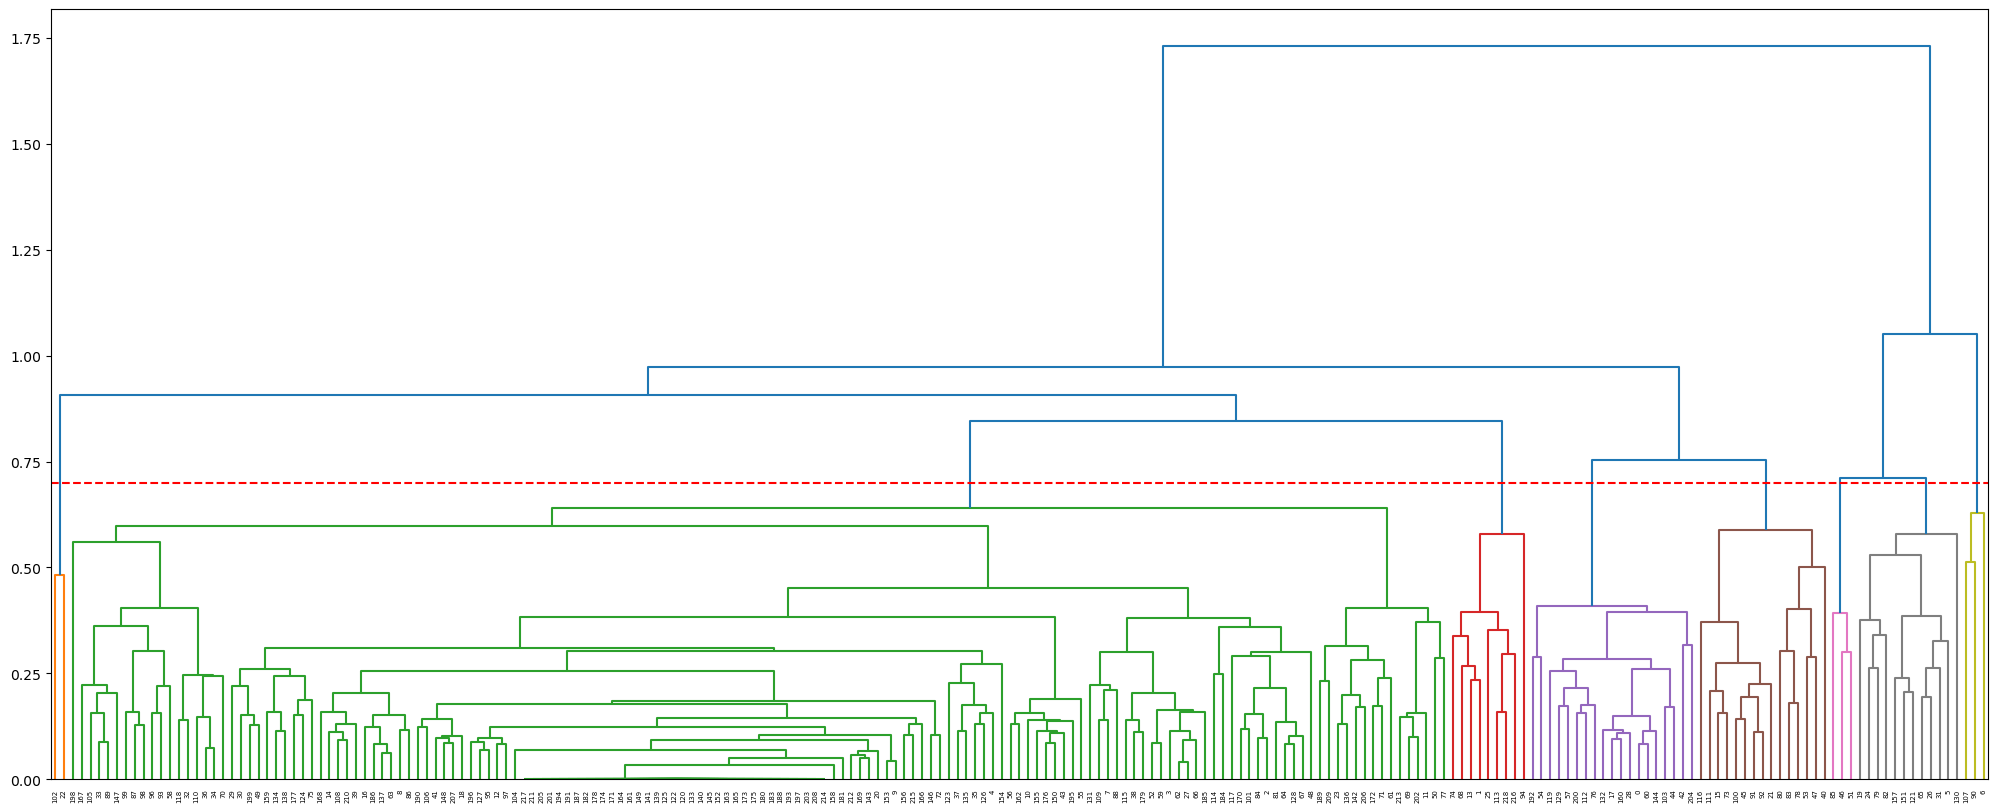

In [49]:
thresh = .7
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(gene_cluster_cd_deep, color_threshold = thresh, get_leaves=True)
# dn = dendrogram(fl)
plt.axhline(y=thresh, c='r', linestyle='--')

In [50]:
dn_ids = np.asarray(dn['ivl'], dtype='int')
dn_ids

array([102,  22, 198, 167, 105,  33,  89, 147,  99,  87,  98,  96,  93,
        58, 118,  32, 110,  36,  34,  70,  29,  30, 199,  49, 159, 134,
       138, 177, 124,  75, 168,  14, 108, 210,  39,  16, 186, 137,  63,
         8,  86, 190, 106,  41, 148, 207,  18, 196, 127,  95,  12,  97,
       104, 217, 211, 205, 201, 194, 191, 187, 182, 178, 174, 171, 164,
       161, 149, 141, 139, 125, 122, 120, 133, 140, 145, 152, 163, 165,
       173, 175, 180, 183, 188, 193, 197, 203, 208, 214, 158, 181, 212,
       169, 143,  20, 153,   9, 156, 215, 166, 146,  72, 123,  37, 135,
        35, 126,   4, 154,  56, 162,  10, 155, 176, 150,  43, 195,  55,
       131, 109,   7,  88, 115,  38, 179,  52,  59,   3,  62,  27,  66,
       185, 114, 184, 117, 170, 101,  84,   2,  81,  64, 128,  67,  48,
       189, 209,  23, 136, 142, 206, 172,  71,  61, 213,  69, 202,  11,
        50,  77,  74,  68,  13,   1,  25, 113, 218, 216,  94, 192,  54,
       119, 129,  57, 200, 112,  76, 132,  17, 160,  28,   0,  6

In [51]:
df_cd_deep.columns

Index(['AADAC', 'APOA1', 'APOA4', 'APOB', 'APOC3', 'AQP9', 'C6', 'CEACAM7',
       'CHI3L1', 'ABCC2',
       ...
       'TAF15', 'ZFYVE20', 'LOC100420253', 'LY6G5B', 'C5orf58', 'RSL24D1P1',
       'MIEN1', 'PCBP1_AS1', 'LOC100133165', 'DNAJB8'],
      dtype='object', length=219)

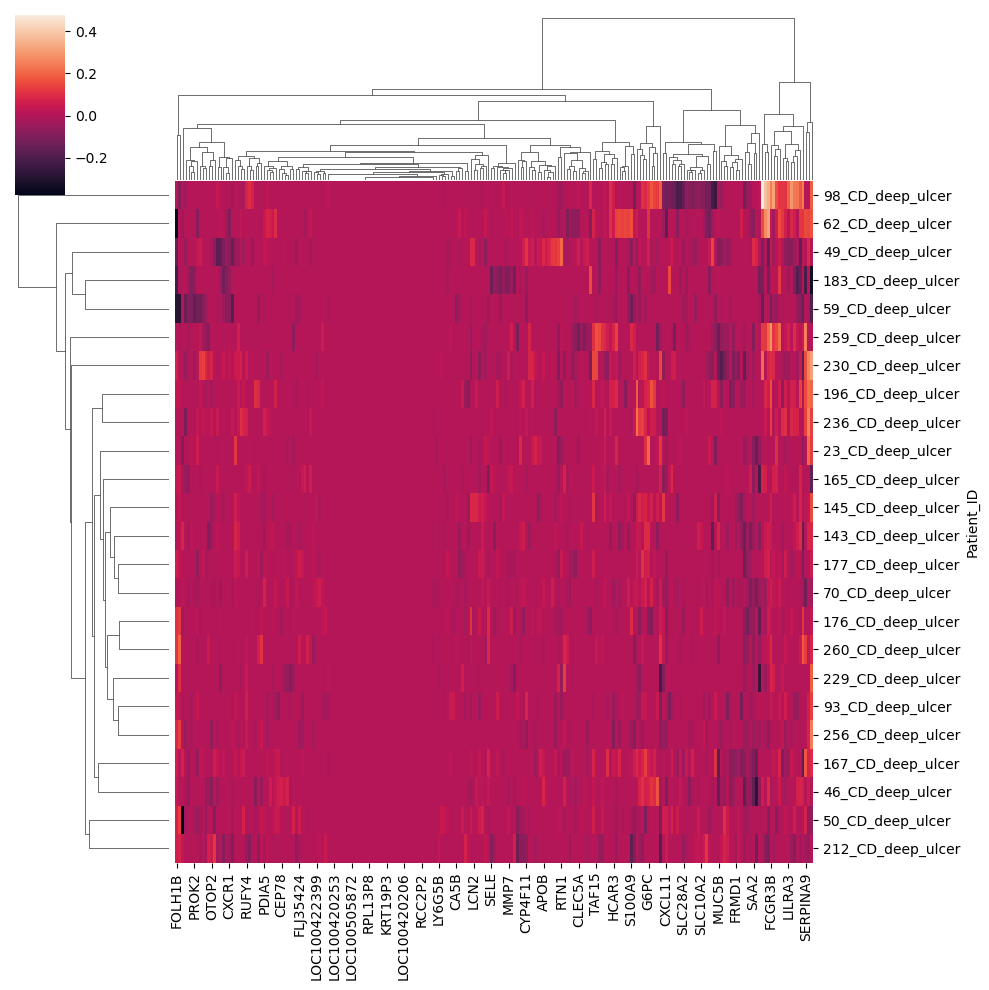

In [52]:
# shap values across genes (CD deep ulcer) - shows contribution of genes to disease symptom prediction for patients with given symptoms

# g = sns.clustermap(df_cd_deep, col_linkage=gc, row_linkage=patient_cluster_cd_deep)
g = sns.clustermap(df_cd_deep, col_linkage=gene_cluster_cd_deep)

## Aggregate bar plot, showing possible gene modules alongside SHAP contributions

In [53]:
gene_cluster_cd_deep

array([[1.22000000e+02, 1.20000000e+02, 0.00000000e+00, 2.00000000e+00],
       [1.25000000e+02, 2.19000000e+02, 0.00000000e+00, 3.00000000e+00],
       [2.20000000e+02, 1.33000000e+02, 0.00000000e+00, 4.00000000e+00],
       [1.39000000e+02, 2.21000000e+02, 0.00000000e+00, 5.00000000e+00],
       [2.22000000e+02, 1.40000000e+02, 0.00000000e+00, 6.00000000e+00],
       [1.41000000e+02, 2.23000000e+02, 0.00000000e+00, 7.00000000e+00],
       [2.24000000e+02, 1.45000000e+02, 0.00000000e+00, 8.00000000e+00],
       [1.49000000e+02, 2.25000000e+02, 0.00000000e+00, 9.00000000e+00],
       [2.26000000e+02, 1.52000000e+02, 0.00000000e+00, 1.00000000e+01],
       [1.61000000e+02, 2.27000000e+02, 0.00000000e+00, 1.10000000e+01],
       [2.28000000e+02, 1.63000000e+02, 0.00000000e+00, 1.20000000e+01],
       [1.64000000e+02, 2.29000000e+02, 0.00000000e+00, 1.30000000e+01],
       [2.30000000e+02, 1.65000000e+02, 0.00000000e+00, 1.40000000e+01],
       [1.71000000e+02, 2.31000000e+02, 0.00000000e

In [54]:
cluster_labels = fcluster(gene_cluster_cd_deep, thresh, criterion='distance')
# label = fcluster(gene_cluster_cd_deep, 8, criterion='maxclust')
cluster_labels.shape

(219,)

In [55]:
leaders(gene_cluster_cd_deep, cluster_labels)

(array([429, 424, 419, 417, 426, 411, 425, 428], dtype=int32),
 array([2, 3, 1, 4, 5, 6, 7, 8], dtype=int32))

In [56]:
leader_ids = leaders(gene_cluster_cd_deep, cluster_labels)[1]
leader_ids

array([2, 3, 1, 4, 5, 6, 7, 8], dtype=int32)

In [57]:
cluster_labels

array([4, 3, 2, 2, 2, 7, 8, 2, 2, 2, 2, 2, 2, 3, 2, 5, 2, 4, 2, 7, 2, 5,
       1, 2, 7, 3, 7, 2, 4, 2, 2, 7, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 4, 2,
       4, 5, 6, 5, 2, 2, 2, 6, 2, 5, 4, 2, 2, 4, 2, 2, 4, 2, 2, 2, 2, 7,
       2, 2, 3, 2, 2, 2, 2, 5, 3, 2, 4, 2, 5, 7, 5, 2, 7, 5, 2, 6, 2, 2,
       2, 2, 8, 5, 5, 2, 3, 2, 2, 2, 2, 2, 5, 2, 1, 4, 2, 2, 2, 8, 2, 2,
       2, 5, 4, 3, 2, 2, 5, 2, 2, 4, 2, 7, 2, 2, 2, 2, 2, 2, 2, 4, 7, 2,
       4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 7, 2, 2,
       2, 2, 2, 7, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2,
       2, 2, 4, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3],
      dtype=int32)

In [58]:
df_cd_deep.columns.get_loc("OSM")

46

In [59]:
np.where(cluster_labels == 2) #osm

(array([  2,   3,   4,   7,   8,   9,  10,  11,  12,  14,  16,  18,  20,
         23,  27,  29,  30,  32,  33,  34,  35,  36,  37,  38,  39,  41,
         43,  48,  49,  50,  52,  55,  56,  58,  59,  61,  62,  63,  64,
         66,  67,  69,  70,  71,  72,  75,  77,  81,  84,  86,  87,  88,
         89,  93,  95,  96,  97,  98,  99, 101, 104, 105, 106, 108, 109,
        110, 114, 115, 117, 118, 120, 122, 123, 124, 125, 126, 127, 128,
        131, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 145,
        146, 147, 148, 149, 150, 152, 153, 154, 155, 156, 158, 159, 161,
        162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174,
        175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187,
        188, 189, 190, 191, 193, 194, 195, 196, 197, 198, 199, 201, 202,
        203, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 217],
       dtype=int64),)

In [60]:
gene_df = df_cd_deep.describe().T
gene_df['gene_symbol']  = df_cd_deep.columns
gene_df["group_num"] = cluster_labels

gene_df

,count,mean,std,min,25%,50%,75%,max,gene_symbol,group_num
AADAC,24.0,0.001998,0.023763,-0.073143,0.000000,0.000000,0.000000,0.058993,AADAC,4
APOA1,24.0,0.035003,0.055080,-0.106595,0.000000,0.018354,0.079605,0.132873,APOA1,3
APOA4,24.0,-0.015557,0.025871,-0.083006,-0.030196,0.000000,0.000000,0.000000,APOA4,2
APOB,24.0,0.009830,0.026094,-0.014483,0.000000,0.000000,0.001709,0.083358,APOB,2
APOC3,24.0,-0.000275,0.024452,-0.067331,0.000000,0.000000,0.000000,0.042356,APOC3,2
...,...,...,...,...,...,...,...,...,...,...
RSL24D1P1,24.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,RSL24D1P1,2
MIEN1,24.0,-0.004278,0.018318,-0.061879,0.000000,0.000000,0.000000,0.044916,MIEN1,2
PCBP1_AS1,24.0,0.007959,0.056327,-0.131688,0.000000,0.000000,0.000000,0.168920,PCBP1_AS1,3
LOC100133165,24.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,LOC100133165,2


In [61]:
# mean_df = gene_df[['mean','group_num']]
mean_df = gene_df[['mean','group_num','gene_symbol']]
mean_df

,mean,group_num,gene_symbol
AADAC,0.001998,4,AADAC
APOA1,0.035003,3,APOA1
APOA4,-0.015557,2,APOA4
APOB,0.009830,2,APOB
APOC3,-0.000275,2,APOC3
...,...,...,...
RSL24D1P1,0.000000,2,RSL24D1P1
MIEN1,-0.004278,2,MIEN1
PCBP1_AS1,0.007959,3,PCBP1_AS1
LOC100133165,0.000000,2,LOC100133165


In [62]:

mean_df["gene_symbol"] = mean_df.index
mean_df


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,mean,group_num,gene_symbol
AADAC,0.001998,4,AADAC
APOA1,0.035003,3,APOA1
APOA4,-0.015557,2,APOA4
APOB,0.009830,2,APOB
APOC3,-0.000275,2,APOC3
...,...,...,...
RSL24D1P1,0.000000,2,RSL24D1P1
MIEN1,-0.004278,2,MIEN1
PCBP1_AS1,0.007959,3,PCBP1_AS1
LOC100133165,0.000000,2,LOC100133165


In [63]:
def group_labels(x):
    if len(x) > 4:
        gene_list = x[:4]
    else:
        gene_list = x
    return ", ".join(gene_list)

def add_other(num, curr_label, max_display=4):
#     print(type(num))
#     print(type(curr_label))
    if num > 1:
        if num > 2: 
            other = " others" 
            num_displayed = min(num, max_display)
        else:
            num_displayed = 2
            other = " other"
        rem = num - num_displayed
        if rem == 0:
            return curr_label
        return curr_label + " + " + str(rem) + other
    else:
        return curr_label


In [64]:

def get_idx_order(dn_ids, df, agg_df):
    g_symbols = np.array(df.columns)
    g_symbols = g_symbols[dn_ids]
    
    genes_from_groups = []
    for li in agg_df["grouped_genes"].values:
        genes_from_groups.append(li[0])
        
    positions_in_dend = [np.where(g_symbols == gene)[0][0] for gene in genes_from_groups]
    idxs = np.arange(1,agg_df.shape[0]+1)
    sorted_idxs = [x for _,x in sorted(zip(positions_in_dend,idxs))]
    return sorted_idxs

In [65]:
# agg_df = mean_df.groupby(['cluster_labels']).agg([group_labels, 'sum', 'count'])
# agg_df = mean_df.groupby(['group_num']).agg(sum=('mean','sum'), 
#       gene_count=('mean','count'), grouped_genes=('gene_symbol', list))

def group_fn(data):
    d = {}
    mean_vals = data['mean']
    symbols = list(data['gene_symbol'])
    print(mean_vals)
    print(symbols)
    mean_dict = {symbols[i]: mean_vals[i] for i in range(len(symbols))}
#     print(mean_dict)
    gene_dict = dict(sorted(mean_dict.items(), key=lambda x : x[1], reverse=True))
    gene_list = list(gene_dict.keys())
#     print(gene_list)
    d['sum'] = np.sum(data['mean'])
    d['gene_count'] = data['mean'].count()
    d['grouped_genes'] = gene_list
    return pd.Series(d)


In [66]:

agg_df = mean_df.groupby(['group_num'])
agg_df = agg_df.apply(group_fn)
agg_df

,sum,gene_count,grouped_genes
group_num,,,
1,0.011634,2,"[FOLH1, FOLH1B]"
2,0.002021,156,"[PPP2R5B, RUFY4, GUCA2B, SNORD89, MIR526A2, TA..."
3,0.180443,9,"[G6PC, APOA1, CYP3A7, OTOP3, NAT8, DNAJB8, PCB..."
4,-0.165590,19,"[NAPG, AADAC, SLC10A2, MRPS7, SLC17A8, RASL11A..."
5,-0.348687,15,"[FABP6, CDHR1, FRMD1, MGAM, FMO1, C9orf71, MUC..."
6,0.098705,3,"[S100A12, OSM, TREM1]"
7,0.213938,12,"[FCGR3B, DHDH, FPR2, LAMC3, TNFAIP6, AQP9, CXC..."
8,0.154963,3,"[AGXT2, C6, SERPINA9]"


In [67]:

# agg_df = mean_df.groupby(['group_num']).agg(sum=('mean','sum'), 
#       gene_count=('mean','count'), grouped_genes=('gene_symbol', 'mean', test))
# result = result.rename(columns={'categorize' : 'Buy/Sell'})
agg_df["cluster_labels"] = agg_df["grouped_genes"].apply(group_labels)
# agg_df["cluster_labels"] = agg_df["count"].apply(add_other)

agg_df['cluster_labels'] = agg_df.apply(lambda x: add_other(x["gene_count"], x["cluster_labels"]), axis=1)
agg_df

,sum,gene_count,grouped_genes,cluster_labels
group_num,,,,
1,0.011634,2,"[FOLH1, FOLH1B]","FOLH1, FOLH1B"
2,0.002021,156,"[PPP2R5B, RUFY4, GUCA2B, SNORD89, MIR526A2, TA...","PPP2R5B, RUFY4, GUCA2B, SNORD89 + 152 others"
3,0.180443,9,"[G6PC, APOA1, CYP3A7, OTOP3, NAT8, DNAJB8, PCB...","G6PC, APOA1, CYP3A7, OTOP3 + 5 others"
4,-0.165590,19,"[NAPG, AADAC, SLC10A2, MRPS7, SLC17A8, RASL11A...","NAPG, AADAC, SLC10A2, MRPS7 + 15 others"
5,-0.348687,15,"[FABP6, CDHR1, FRMD1, MGAM, FMO1, C9orf71, MUC...","FABP6, CDHR1, FRMD1, MGAM + 11 others"
6,0.098705,3,"[S100A12, OSM, TREM1]","S100A12, OSM, TREM1"
7,0.213938,12,"[FCGR3B, DHDH, FPR2, LAMC3, TNFAIP6, AQP9, CXC...","FCGR3B, DHDH, FPR2, LAMC3 + 8 others"
8,0.154963,3,"[AGXT2, C6, SERPINA9]","AGXT2, C6, SERPINA9"


In [68]:
sorted_idxs = get_idx_order(dn_ids, df_cd_deep, agg_df)

In [69]:
# agg_df.index = leader_ids
agg_df.index = sorted_idxs
agg_df

,sum,gene_count,grouped_genes,cluster_labels
1,0.011634,2,"[FOLH1, FOLH1B]","FOLH1, FOLH1B"
2,0.002021,156,"[PPP2R5B, RUFY4, GUCA2B, SNORD89, MIR526A2, TA...","PPP2R5B, RUFY4, GUCA2B, SNORD89 + 152 others"
3,0.180443,9,"[G6PC, APOA1, CYP3A7, OTOP3, NAT8, DNAJB8, PCB...","G6PC, APOA1, CYP3A7, OTOP3 + 5 others"
4,-0.165590,19,"[NAPG, AADAC, SLC10A2, MRPS7, SLC17A8, RASL11A...","NAPG, AADAC, SLC10A2, MRPS7 + 15 others"
5,-0.348687,15,"[FABP6, CDHR1, FRMD1, MGAM, FMO1, C9orf71, MUC...","FABP6, CDHR1, FRMD1, MGAM + 11 others"
6,0.098705,3,"[S100A12, OSM, TREM1]","S100A12, OSM, TREM1"
7,0.213938,12,"[FCGR3B, DHDH, FPR2, LAMC3, TNFAIP6, AQP9, CXC...","FCGR3B, DHDH, FPR2, LAMC3 + 8 others"
8,0.154963,3,"[AGXT2, C6, SERPINA9]","AGXT2, C6, SERPINA9"


In [70]:
agg_df = agg_df.sort_index()
agg_df

,sum,gene_count,grouped_genes,cluster_labels
1,0.011634,2,"[FOLH1, FOLH1B]","FOLH1, FOLH1B"
2,0.002021,156,"[PPP2R5B, RUFY4, GUCA2B, SNORD89, MIR526A2, TA...","PPP2R5B, RUFY4, GUCA2B, SNORD89 + 152 others"
3,0.180443,9,"[G6PC, APOA1, CYP3A7, OTOP3, NAT8, DNAJB8, PCB...","G6PC, APOA1, CYP3A7, OTOP3 + 5 others"
4,-0.165590,19,"[NAPG, AADAC, SLC10A2, MRPS7, SLC17A8, RASL11A...","NAPG, AADAC, SLC10A2, MRPS7 + 15 others"
5,-0.348687,15,"[FABP6, CDHR1, FRMD1, MGAM, FMO1, C9orf71, MUC...","FABP6, CDHR1, FRMD1, MGAM + 11 others"
6,0.098705,3,"[S100A12, OSM, TREM1]","S100A12, OSM, TREM1"
7,0.213938,12,"[FCGR3B, DHDH, FPR2, LAMC3, TNFAIP6, AQP9, CXC...","FCGR3B, DHDH, FPR2, LAMC3 + 8 others"
8,0.154963,3,"[AGXT2, C6, SERPINA9]","AGXT2, C6, SERPINA9"


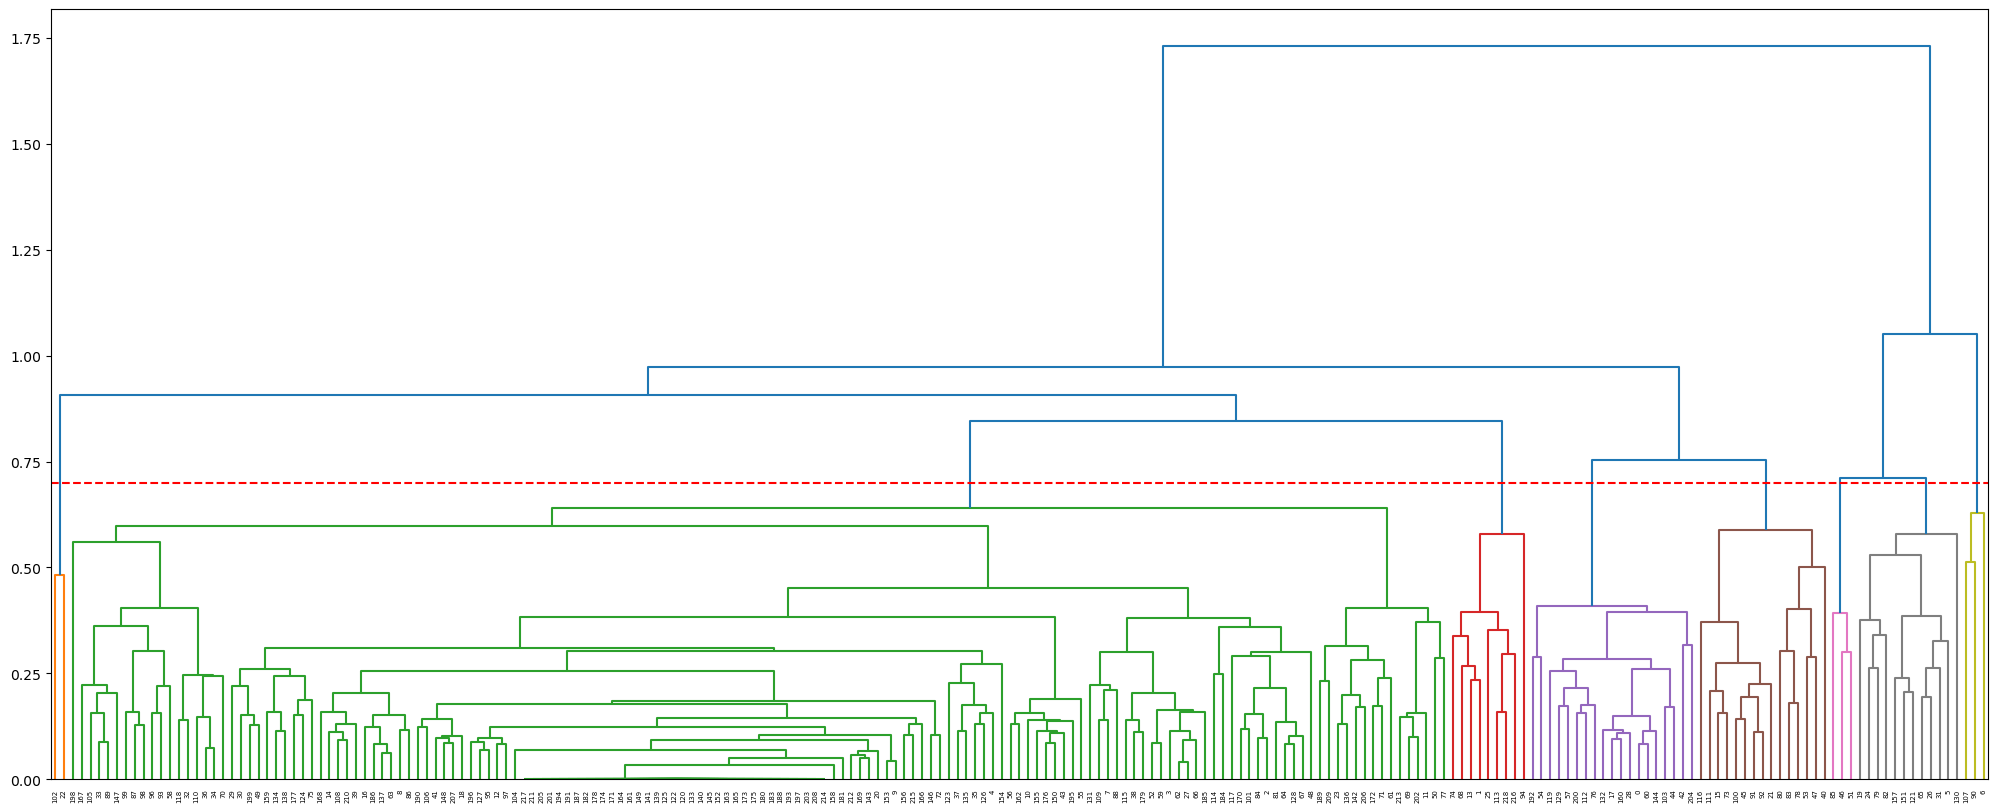

In [71]:
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(gene_cluster_cd_deep, color_threshold = thresh)
plt.axhline(y=thresh, c='r', linestyle='--')

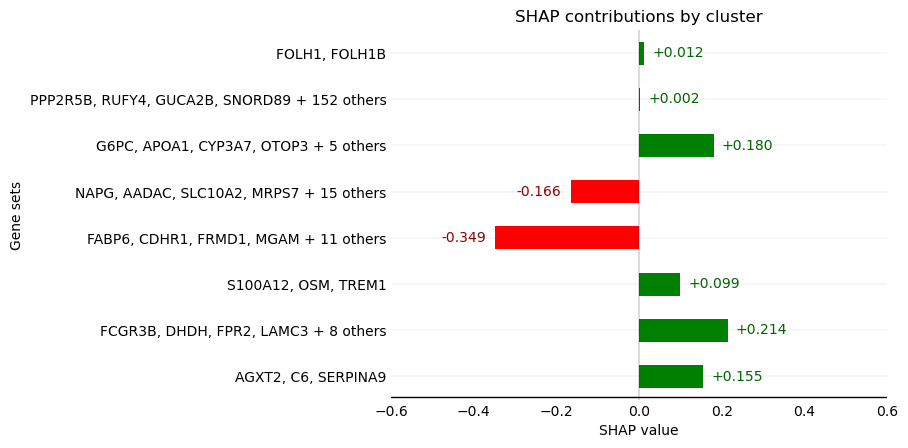

In [72]:
agg_df.plot.barh(x="cluster_labels", y="sum", legend=None, zorder=2, color=(agg_df['sum'] > 0).map({True: 'g',False: 'r'}))

plt.title('SHAP contributions by cluster')
plt.ylabel('Gene sets')
plt.xlabel('SHAP value')
plt.xlim((-.6,.6))
for i, v in enumerate(agg_df["sum"]):
    v = np.round(v, 3)
    vt = "+{:.3f}".format(v) if v >= 0 else "{:.3f}".format(v)
    offset = -.13 if v < 0 else .02
    colour = 'darkred' if v < 0 else 'darkgreen'
    plt.text(v + offset, i + .08, vt, color=colour, zorder=3)
    plt.axhline(i,linewidth=.07, color='k', zorder=1, linestyle='--')
    
    
plt.axvline(0,linewidth=.2, color='k')
plt.axhline(7.45,linewidth=1., color='k')

plt.tick_params(axis=u'both', which=u'both',length=0)
plt.gca().invert_yaxis()
plt.box(on=False)

plt.show()

gene names shown in sorted order;
can get full lists from dataframe;
clusters correspond to above dendrogram from left to right;
can choose threshold to get more / fewer clusters

In [73]:
# export to text file

for li in agg_df["grouped_genes"]:
    print(len(li),"genes:")
    for item in li:
        print(item)
    print("----------------------")

### Example: CD no ulcer patients

In [74]:
# patient_cluster_cd_deep = linkage(df_cd_deep, 'ward', metric='euclidean', optimal_ordering=True)
gene_cluster_cd_plain = linkage(df_cd_plain.T, 'ward', metric='euclidean', optimal_ordering=True)

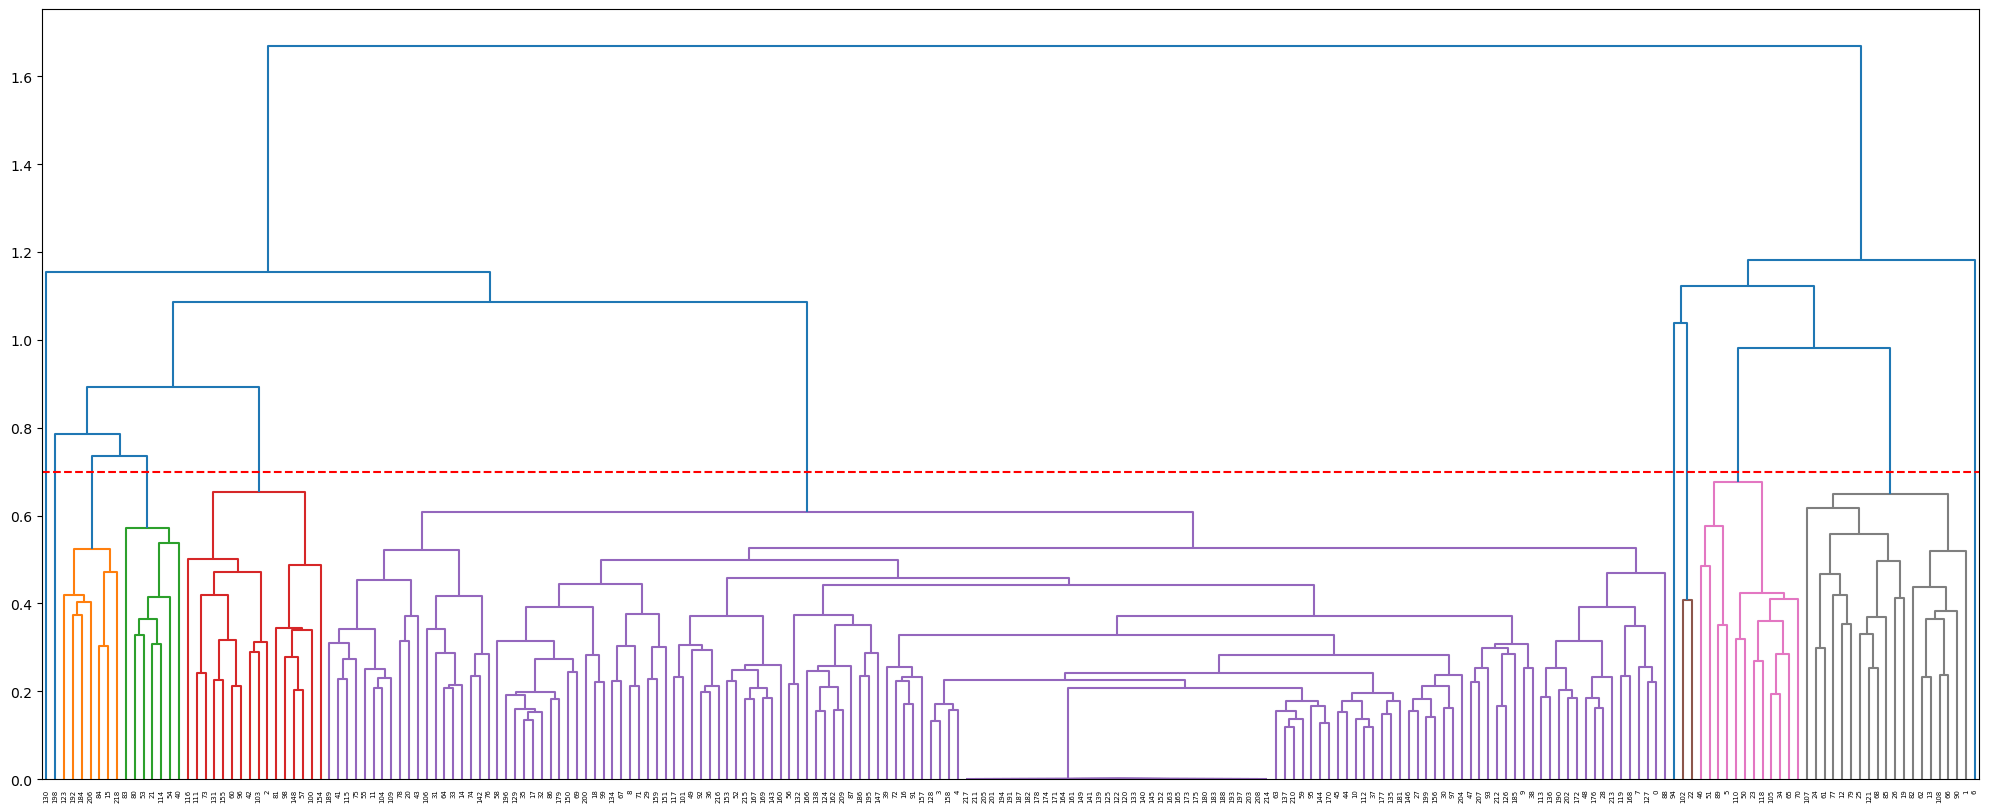

In [75]:

fig = plt.figure(figsize=(25, 10))
dn = dendrogram(gene_cluster_cd_plain, color_threshold = thresh)
# dn = dendrogram(fl)
plt.axhline(y=thresh, c='r', linestyle='--')

In [76]:
dn_ids = np.asarray(dn['ivl'], dtype='int')
dn_ids

array([130, 198, 123, 192, 184, 206,  84,  15, 218,  83,  80,  53,  21,
       114,  54,  40, 116, 111,  73, 131, 155,  60,  96,  42, 103,   2,
        81,  98, 148,  57, 100, 154, 189,  41, 115,  75,  55,  11, 104,
       109,  78,  20,  43, 106,  31,  64,  33,  14,  74, 142,  76,  58,
       196, 129,  35,  17,  32,  86, 179, 150,  69, 200,  18,  99, 134,
        67,   8,  71,  29, 159, 151, 117, 101,  49,  92,  36, 216, 153,
        52, 215, 167, 169, 143, 160,  56, 132, 166, 138, 124, 162, 209,
        87, 186, 195, 147,  39,  72,  16,  91, 157, 128,   3, 158,   4,
       217, 211, 205, 201, 194, 191, 187, 182, 178, 174, 171, 164, 161,
       149, 141, 139, 125, 122, 120, 133, 140, 145, 152, 163, 165, 173,
       175, 180, 183, 188, 193, 197, 203, 208, 214,  63, 137, 210,  59,
        95, 144, 170,  45,  44,  10, 112,  37, 177, 135, 181, 146,  27,
       199, 156,  30,  97, 204,  47, 207,  93, 212, 126, 185,   9,  38,
       113, 136, 190, 202, 172,  48, 176,  28, 213, 119, 168,   

In [77]:
df_cd_plain.columns

Index(['AADAC', 'APOA1', 'APOA4', 'APOB', 'APOC3', 'AQP9', 'C6', 'CEACAM7',
       'CHI3L1', 'ABCC2',
       ...
       'TAF15', 'ZFYVE20', 'LOC100420253', 'LY6G5B', 'C5orf58', 'RSL24D1P1',
       'MIEN1', 'PCBP1_AS1', 'LOC100133165', 'DNAJB8'],
      dtype='object', length=219)

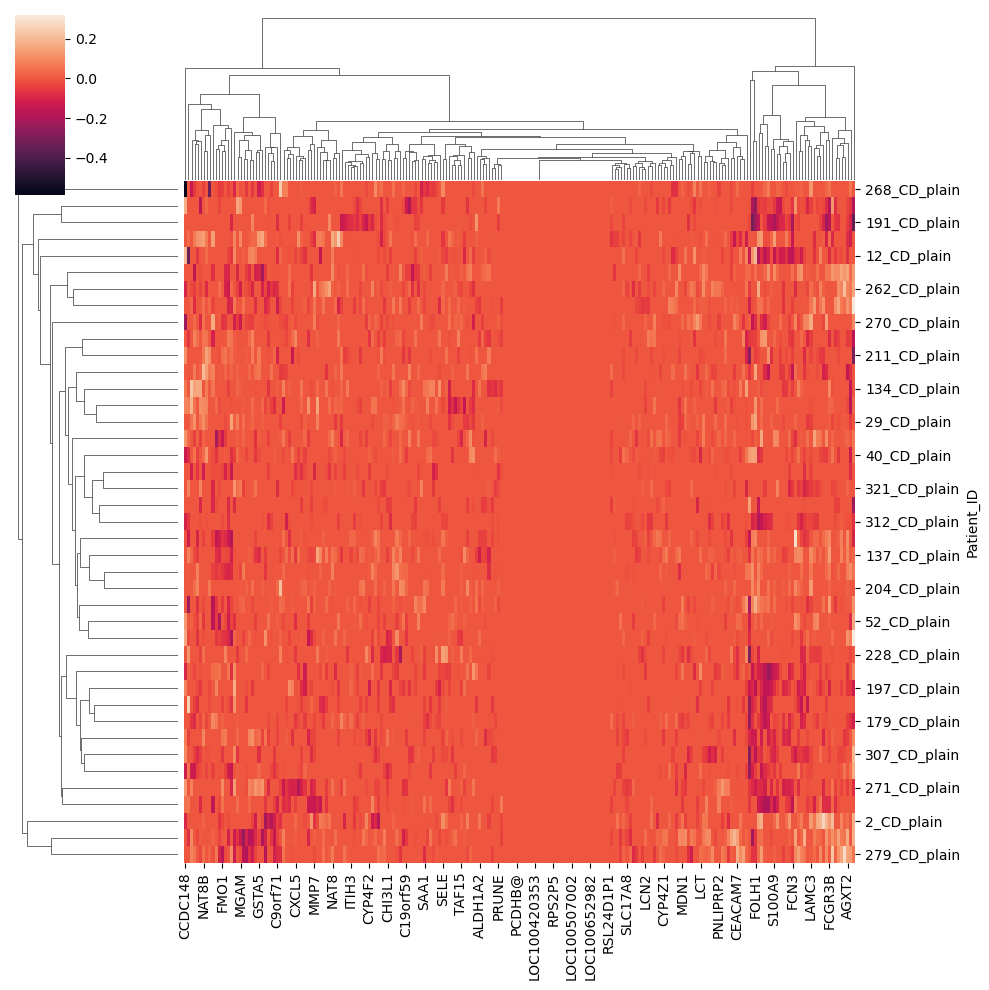

In [78]:
# shap values across genes (CD deep ulcer) - shows contribution of genes to disease symptom prediction for patients with given symptoms

# g = sns.clustermap(df_cd_deep, col_linkage=gc, row_linkage=patient_cluster_cd_deep)
g = sns.clustermap(df_cd_plain, col_linkage=gene_cluster_cd_plain)

## Aggregate bar plot, showing possible gene modules alongside SHAP contributions

In [79]:
gene_cluster_cd_plain

array([[1.22000000e+02, 1.20000000e+02, 0.00000000e+00, 2.00000000e+00],
       [1.25000000e+02, 2.19000000e+02, 0.00000000e+00, 3.00000000e+00],
       [2.20000000e+02, 1.33000000e+02, 0.00000000e+00, 4.00000000e+00],
       [1.39000000e+02, 2.21000000e+02, 0.00000000e+00, 5.00000000e+00],
       [2.22000000e+02, 1.40000000e+02, 0.00000000e+00, 6.00000000e+00],
       [1.41000000e+02, 2.23000000e+02, 0.00000000e+00, 7.00000000e+00],
       [2.24000000e+02, 1.45000000e+02, 0.00000000e+00, 8.00000000e+00],
       [1.49000000e+02, 2.25000000e+02, 0.00000000e+00, 9.00000000e+00],
       [2.26000000e+02, 1.52000000e+02, 0.00000000e+00, 1.00000000e+01],
       [1.61000000e+02, 2.27000000e+02, 0.00000000e+00, 1.10000000e+01],
       [2.28000000e+02, 1.63000000e+02, 0.00000000e+00, 1.20000000e+01],
       [1.64000000e+02, 2.29000000e+02, 0.00000000e+00, 1.30000000e+01],
       [2.30000000e+02, 1.65000000e+02, 0.00000000e+00, 1.40000000e+01],
       [1.71000000e+02, 2.31000000e+02, 0.00000000e

In [80]:
cluster_labels = fcluster(gene_cluster_cd_plain, thresh, criterion='distance')
# cluster_labels = fcluster(gene_cluster_cd_plain, 8, criterion='maxclust')
cluster_labels.shape

(219,)

In [81]:
leaders(gene_cluster_cd_plain, cluster_labels)

(array([416, 420, 198, 425, 422, 130,  94, 391, 426, 424,   6], dtype=int32),
 array([ 1,  2,  3,  4,  5,  6,  8,  7,  9, 10, 11], dtype=int32))

In [82]:
leader_ids = leaders(gene_cluster_cd_plain, cluster_labels)[1]
leader_ids

array([ 1,  2,  3,  4,  5,  6,  8,  7,  9, 10, 11], dtype=int32)

In [83]:
cluster_labels

array([ 5, 10,  4,  5,  5,  9, 11,  5,  5,  5,  5,  5, 10, 10,  5,  1,  5,
        5,  5, 10,  5,  2,  7,  9, 10, 10, 10,  5,  5,  5,  5,  5,  5,  5,
        9,  5,  5,  5,  5,  5,  2,  5,  4,  5,  5,  5,  9,  5,  5,  5,  9,
        9,  5,  2,  2,  5,  5,  4,  5,  5,  4, 10, 10,  5,  5,  9, 10,  5,
       10,  5,  9,  5,  5,  4,  5,  5,  5, 10,  5, 10,  2,  4, 10,  2,  1,
       10,  5,  5,  5,  9, 10,  5,  5,  5,  8,  5,  4,  5,  4,  5,  4,  5,
        7,  4,  5,  9,  5, 10, 10,  5,  9,  4,  5,  5,  2,  5,  4,  5,  9,
        5,  5, 10,  5,  1,  5,  5,  5,  5,  5,  5,  6,  4,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  4,  5,  5,  5,  5,
        5,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  1,  5,  5,
        5,  5,  5,  5,  5,  1,  5,  5,  5,  5,  5,  3,  5,  5,  5,  5,  5,
        5,  5,  1,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  1],
      dtype=int32)

In [84]:
gene_df = df_cd_plain.describe().T
gene_df['gene_symbol']  = df_cd_plain.columns
gene_df["group_num"] = cluster_labels

gene_df

,count,mean,std,min,25%,50%,75%,max,gene_symbol,group_num
AADAC,41.0,0.006289,0.032023,-0.064152,0.000000,0.0,0.0,0.147216,AADAC,5
APOA1,41.0,-0.015680,0.066749,-0.171522,-0.056834,0.0,0.0,0.136600,APOA1,10
APOA4,41.0,-0.007214,0.060234,-0.218746,0.000000,0.0,0.0,0.161790,APOA4,4
APOB,41.0,-0.003954,0.018957,-0.083550,0.000000,0.0,0.0,0.042039,APOB,5
APOC3,41.0,-0.004876,0.020065,-0.061323,0.000000,0.0,0.0,0.075269,APOC3,5
...,...,...,...,...,...,...,...,...,...,...
RSL24D1P1,41.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,RSL24D1P1,5
MIEN1,41.0,0.001151,0.026881,-0.087223,0.000000,0.0,0.0,0.081447,MIEN1,5
PCBP1_AS1,41.0,0.003556,0.027296,-0.077381,0.000000,0.0,0.0,0.085956,PCBP1_AS1,5
LOC100133165,41.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,LOC100133165,5


In [85]:
# mean_df = gene_df[['mean','group_num']]
mean_df = gene_df[['mean','group_num','gene_symbol']]
mean_df

,mean,group_num,gene_symbol
AADAC,0.006289,5,AADAC
APOA1,-0.015680,10,APOA1
APOA4,-0.007214,4,APOA4
APOB,-0.003954,5,APOB
APOC3,-0.004876,5,APOC3
...,...,...,...
RSL24D1P1,0.000000,5,RSL24D1P1
MIEN1,0.001151,5,MIEN1
PCBP1_AS1,0.003556,5,PCBP1_AS1
LOC100133165,0.000000,5,LOC100133165


In [86]:

mean_df["gene_symbol"] = mean_df.index
mean_df


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,mean,group_num,gene_symbol
AADAC,0.006289,5,AADAC
APOA1,-0.015680,10,APOA1
APOA4,-0.007214,4,APOA4
APOB,-0.003954,5,APOB
APOC3,-0.004876,5,APOC3
...,...,...,...
RSL24D1P1,0.000000,5,RSL24D1P1
MIEN1,0.001151,5,MIEN1
PCBP1_AS1,0.003556,5,PCBP1_AS1
LOC100133165,0.000000,5,LOC100133165


In [87]:
agg_df = mean_df.groupby(['group_num'])
agg_df = agg_df.apply(group_fn)
agg_df

,sum,gene_count,grouped_genes
group_num,,,
1,0.027206,7,"[NAT8B, FABP6, RALY, 42064, DNAJB8, PSME1, RTN1]"
2,-0.131777,7,"[DUOX2, SLC6A14, LOC392364, FMO1, SAA2, CXCL9,..."
3,-0.005334,1,[KIF1A]
4,-0.101062,16,"[MUC5B, LRRC43, MS4A10, CPO, GSTA5, SLC10A2, M..."
5,-0.204331,152,"[NAT8, OTOP3, VPS26B, FLJ35424, GUCA2B, CYP3A4..."
6,-0.000203,1,[CCDC148]
7,-0.041382,2,"[FOLH1, FOLH1B]"
8,-0.063503,1,[BPIFB1]
9,-0.238008,12,"[FPR1, S100A12, LOC100506115, OSM, CXCR1, S100..."


In [88]:

# agg_df = mean_df.groupby(['group_num']).agg(sum=('mean','sum'), 
#       gene_count=('mean','count'), grouped_genes=('gene_symbol', 'mean', test))
# result = result.rename(columns={'categorize' : 'Buy/Sell'})
agg_df["cluster_labels"] = agg_df["grouped_genes"].apply(group_labels)
# agg_df["cluster_labels"] = agg_df["count"].apply(add_other)

agg_df['cluster_labels'] = agg_df.apply(lambda x: add_other(x["gene_count"], x["cluster_labels"]), axis=1)
agg_df

,sum,gene_count,grouped_genes,cluster_labels
group_num,,,,
1,0.027206,7,"[NAT8B, FABP6, RALY, 42064, DNAJB8, PSME1, RTN1]","NAT8B, FABP6, RALY, 42064 + 3 others"
2,-0.131777,7,"[DUOX2, SLC6A14, LOC392364, FMO1, SAA2, CXCL9,...","DUOX2, SLC6A14, LOC392364, FMO1 + 3 others"
3,-0.005334,1,[KIF1A],KIF1A
4,-0.101062,16,"[MUC5B, LRRC43, MS4A10, CPO, GSTA5, SLC10A2, M...","MUC5B, LRRC43, MS4A10, CPO + 12 others"
5,-0.204331,152,"[NAT8, OTOP3, VPS26B, FLJ35424, GUCA2B, CYP3A4...","NAT8, OTOP3, VPS26B, FLJ35424 + 148 others"
6,-0.000203,1,[CCDC148],CCDC148
7,-0.041382,2,"[FOLH1, FOLH1B]","FOLH1, FOLH1B"
8,-0.063503,1,[BPIFB1],BPIFB1
9,-0.238008,12,"[FPR1, S100A12, LOC100506115, OSM, CXCR1, S100...","FPR1, S100A12, LOC100506115, OSM + 8 others"


In [89]:
sorted_idxs = get_idx_order(dn_ids, df_cd_plain, agg_df)

In [90]:
# agg_df.index = leader_ids
agg_df.index = sorted_idxs
agg_df

,sum,gene_count,grouped_genes,cluster_labels
6,0.027206,7,"[NAT8B, FABP6, RALY, 42064, DNAJB8, PSME1, RTN1]","NAT8B, FABP6, RALY, 42064 + 3 others"
3,-0.131777,7,"[DUOX2, SLC6A14, LOC392364, FMO1, SAA2, CXCL9,...","DUOX2, SLC6A14, LOC392364, FMO1 + 3 others"
1,-0.005334,1,[KIF1A],KIF1A
2,-0.101062,16,"[MUC5B, LRRC43, MS4A10, CPO, GSTA5, SLC10A2, M...","MUC5B, LRRC43, MS4A10, CPO + 12 others"
4,-0.204331,152,"[NAT8, OTOP3, VPS26B, FLJ35424, GUCA2B, CYP3A4...","NAT8, OTOP3, VPS26B, FLJ35424 + 148 others"
5,-0.000203,1,[CCDC148],CCDC148
8,-0.041382,2,"[FOLH1, FOLH1B]","FOLH1, FOLH1B"
7,-0.063503,1,[BPIFB1],BPIFB1
9,-0.238008,12,"[FPR1, S100A12, LOC100506115, OSM, CXCR1, S100...","FPR1, S100A12, LOC100506115, OSM + 8 others"
10,0.057277,19,"[DHDH, XPNPEP2, SERPINA9, FAM151A, AGXT2, SOAT...","DHDH, XPNPEP2, SERPINA9, FAM151A + 15 others"


In [91]:
agg_df = agg_df.sort_index()
agg_df

,sum,gene_count,grouped_genes,cluster_labels
1,-0.005334,1,[KIF1A],KIF1A
2,-0.101062,16,"[MUC5B, LRRC43, MS4A10, CPO, GSTA5, SLC10A2, M...","MUC5B, LRRC43, MS4A10, CPO + 12 others"
3,-0.131777,7,"[DUOX2, SLC6A14, LOC392364, FMO1, SAA2, CXCL9,...","DUOX2, SLC6A14, LOC392364, FMO1 + 3 others"
4,-0.204331,152,"[NAT8, OTOP3, VPS26B, FLJ35424, GUCA2B, CYP3A4...","NAT8, OTOP3, VPS26B, FLJ35424 + 148 others"
5,-0.000203,1,[CCDC148],CCDC148
6,0.027206,7,"[NAT8B, FABP6, RALY, 42064, DNAJB8, PSME1, RTN1]","NAT8B, FABP6, RALY, 42064 + 3 others"
7,-0.063503,1,[BPIFB1],BPIFB1
8,-0.041382,2,"[FOLH1, FOLH1B]","FOLH1, FOLH1B"
9,-0.238008,12,"[FPR1, S100A12, LOC100506115, OSM, CXCR1, S100...","FPR1, S100A12, LOC100506115, OSM + 8 others"
10,0.057277,19,"[DHDH, XPNPEP2, SERPINA9, FAM151A, AGXT2, SOAT...","DHDH, XPNPEP2, SERPINA9, FAM151A + 15 others"


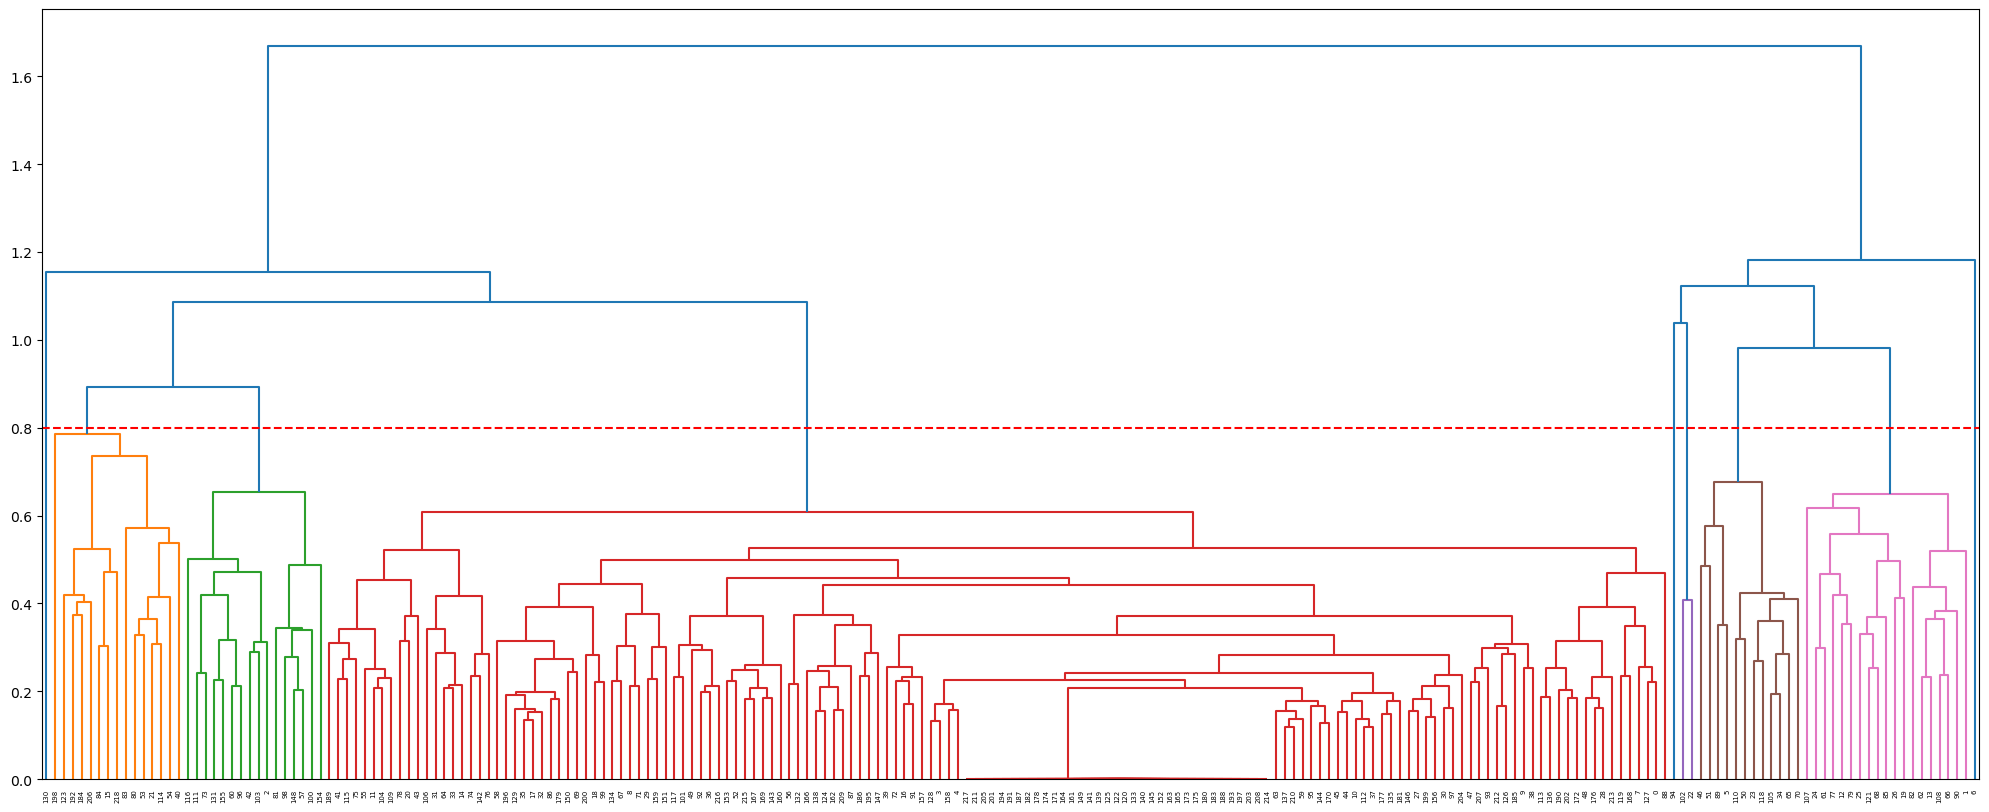

In [92]:
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(gene_cluster_cd_plain, color_threshold=.8, get_leaves=True)
plt.axhline(y=.8, c='r', linestyle='--')

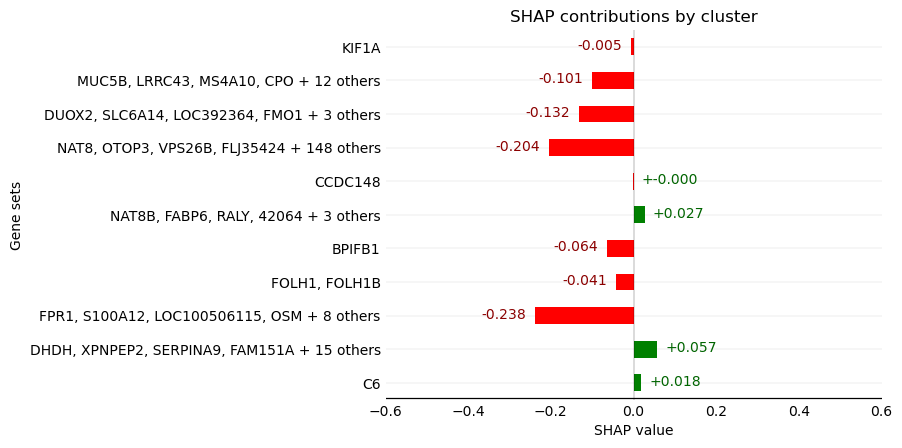

In [93]:
agg_df.plot.barh(x="cluster_labels", y="sum", legend=None, zorder=2, color=(agg_df['sum'] > 0).map({True: 'g',False: 'r'}))

plt.title('SHAP contributions by cluster')
plt.ylabel('Gene sets')
plt.xlabel('SHAP value')
plt.xlim((-.6,.6))
for i, v in enumerate(agg_df["sum"]):
    v = np.round(v, 3)
    vt = "+{:.3f}".format(v) if v >= 0 else "{:.3f}".format(v)
    offset = -.13 if v < 0 else .02
    colour = 'darkred' if v < 0 else 'darkgreen'
    plt.text(v + offset, i + .08, vt, color=colour, zorder=3)
    plt.axhline(i,linewidth=.07, color='k', zorder=1, linestyle='--')
    
    
plt.axvline(0,linewidth=.2, color='k')
size = fig.get_size_inches()[1]
plt.axhline(size + .045*size,linewidth=.9, color='k')

plt.tick_params(axis=u'both', which=u'both',length=0)
plt.gca().invert_yaxis()
plt.box(on=False)

plt.show()

gene names shown in sorted order;
can get full lists from dataframe
clusters correspond to above dendrogram from left to right
can choose threshold to get more / fewer clusters

In [94]:
# export to text file

for li in agg_df["grouped_genes"]:
    print(len(li),"genes:")
    for item in li:
        print(item)
    print("----------------------")